In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
#The usual collection of indispensables 
import numpy as np
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm
import scipy.fftpack
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error, explained_variance_score, max_error
from sklearn.model_selection import cross_val_score, train_test_split

In [2]:
from helpers import sample_data, load_data

# load data.
data_oligo_1 = np.delete(load_data("data/data-oligo/011021_SFL_SYN211_Oligo_1uM_Rawdata_270spectralcolumns.csv"), 0, 1).T
data_oligo_1 = data_oligo_1[data_oligo_1[:, 0] != -999, :]
data_oligo_2 = np.delete(load_data("data/data-oligo/051021_SFL_SYN211_Oligo_5uM_rawdata_270spectralcolumns.csv"), 0, 1).T
data_oligo_2 = data_oligo_2[data_oligo_2[:, 0] != -999, :]
data_oligo = np.append(data_oligo_1, data_oligo_2, axis = 0)
y_oligo = np.expand_dims(np.zeros(len(data_oligo)), axis=1)

data_PFF1 = np.delete(load_data("data/data-pff/191121_G80_AInII_SYn211_AsynPFF_5microM_rawdata_290spectracolumns.csv"), 0, 1).T
data_PFF1 = data_PFF1[data_PFF1[:, 0] != -999, :]
data_PFF2 = np.delete(load_data("data/data-pff/220421_G80_AInII_SYn211_AsynPFF_20microM_880_spectralcolumns.csv"), 0, 1).T
data_PFF2 = data_PFF2[data_PFF2[:, 0] != -999, :]
data_PFF =  np.append(data_PFF1, data_PFF2, axis = 0)
y_PFF = np.expand_dims(np.ones(len(data_PFF)), axis=1)

print(data_oligo.shape, data_PFF.shape)

(540, 133) (1170, 133)


In [3]:
#Build X and y by concatenating the different dataset (after sampling the same number of datapoints for each dataset)
np.random.seed(2)
X = np.concatenate((data_oligo[np.random.randint(data_oligo.shape[0], size=540),:], data_PFF[np.random.randint(data_PFF.shape[0], size=540),:]), axis = 0)
y = np.concatenate((y_oligo[np.random.randint(y_oligo.shape[0], size=540),:], y_PFF[np.random.randint(y_PFF.shape[0], size=540),:]), axis = 0)

# Train and test
x_train, _, y_train, _ = train_test_split(X, y, random_state=42)


In [4]:
def train(features, labels, model, lossfunc, optimizer, num_epoch):

    for epoch in range(num_epoch):
        inputs = torch.from_numpy(features)
        targets = torch.from_numpy(labels)

        outputs = model(inputs.float())
        loss = lossfunc(outputs, targets.float())
        
        optimizer.zero_grad()  
        loss.backward()
        optimizer.step()
        
        if epoch % 10 == 0:
            print ('Epoch [%d/%d], Loss: %.4f' %(epoch+1, num_epoch, loss.item()))
        
        
def visualize(x_train, y_train, model):

    predicted = model(torch.from_numpy(x_train).float()).data.numpy()
    predicted = (predicted >= 1/2).astype(int)
    order = np.argsort(x_train, axis=0)
    missed = np.absolute(y_te - output)
    plt.plot(missed[missed > 0], 'ro', label='Misclassified data')
    plt.legend()
    plt.show()

## MLP

In [5]:
class MLP(nn.Module):
    def __init__(self, hidden_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(133, hidden_size)
        self.activation_fn1 = nn.Sigmoid() 
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.activation_fn2 = nn.Sigmoid() 
        self.fc3 = nn.Linear(hidden_size, 1)
        self.activation_fn3 = nn.Sigmoid() 
    
    def forward(self, x):
        out1 = self.fc2(self.activation_fn1(self.fc1(x)))
        out2 = self.fc3(self.activation_fn2(out1))
        return self.activation_fn3(out2)
    
hidden_size = 10
learning_rate = 1e-1
lossfunc = nn.MSELoss()

model = MLP(hidden_size=hidden_size)

optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)

In [6]:
def build_k_indices(y, k_fold):
    
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed()
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval] for k in range(k_fold)]
    return np.array(k_indices)

Epoch [1/500], Loss: 0.2700
Epoch [11/500], Loss: 0.2349
Epoch [21/500], Loss: 0.2050
Epoch [31/500], Loss: 0.1770
Epoch [41/500], Loss: 0.1118
Epoch [51/500], Loss: 0.0662
Epoch [61/500], Loss: 0.0485
Epoch [71/500], Loss: 0.0414
Epoch [81/500], Loss: 0.0349
Epoch [91/500], Loss: 0.0284
Epoch [101/500], Loss: 0.0239
Epoch [111/500], Loss: 0.0205
Epoch [121/500], Loss: 0.0177
Epoch [131/500], Loss: 0.0162
Epoch [141/500], Loss: 0.0150
Epoch [151/500], Loss: 0.0130
Epoch [161/500], Loss: 0.0084
Epoch [171/500], Loss: 0.0051
Epoch [181/500], Loss: 0.0034
Epoch [191/500], Loss: 0.0025
Epoch [201/500], Loss: 0.0020
Epoch [211/500], Loss: 0.0017
Epoch [221/500], Loss: 0.0015
Epoch [231/500], Loss: 0.0014
Epoch [241/500], Loss: 0.0012
Epoch [251/500], Loss: 0.0011
Epoch [261/500], Loss: 0.0009
Epoch [271/500], Loss: 0.0008
Epoch [281/500], Loss: 0.0006
Epoch [291/500], Loss: 0.0005
Epoch [301/500], Loss: 0.0004
Epoch [311/500], Loss: 0.0003
Epoch [321/500], Loss: 0.0003
Epoch [331/500], Loss

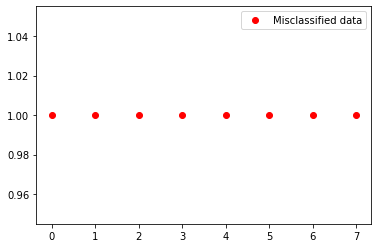

Epoch [1/500], Loss: 0.0128
Epoch [11/500], Loss: 0.0093
Epoch [21/500], Loss: 0.0061
Epoch [31/500], Loss: 0.0054
Epoch [41/500], Loss: 0.0050
Epoch [51/500], Loss: 0.0039
Epoch [61/500], Loss: 0.0022
Epoch [71/500], Loss: 0.0020
Epoch [81/500], Loss: 0.0019
Epoch [91/500], Loss: 0.0018
Epoch [101/500], Loss: 0.0018
Epoch [111/500], Loss: 0.0017
Epoch [121/500], Loss: 0.0017
Epoch [131/500], Loss: 0.0012
Epoch [141/500], Loss: 0.0004
Epoch [151/500], Loss: 0.0002
Epoch [161/500], Loss: 0.0002
Epoch [171/500], Loss: 0.0001
Epoch [181/500], Loss: 0.0001
Epoch [191/500], Loss: 0.0001
Epoch [201/500], Loss: 0.0001
Epoch [211/500], Loss: 0.0001
Epoch [221/500], Loss: 0.0001
Epoch [231/500], Loss: 0.0001
Epoch [241/500], Loss: 0.0001
Epoch [251/500], Loss: 0.0001
Epoch [261/500], Loss: 0.0001
Epoch [271/500], Loss: 0.0001
Epoch [281/500], Loss: 0.0001
Epoch [291/500], Loss: 0.0001
Epoch [301/500], Loss: 0.0001
Epoch [311/500], Loss: 0.0001
Epoch [321/500], Loss: 0.0001
Epoch [331/500], Loss

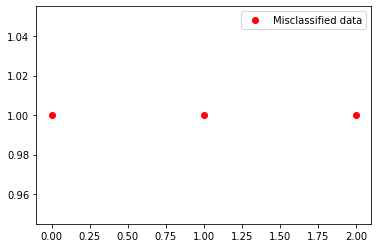

Epoch [1/500], Loss: 0.0040
Epoch [11/500], Loss: 0.0003
Epoch [21/500], Loss: 0.0002
Epoch [31/500], Loss: 0.0001
Epoch [41/500], Loss: 0.0001
Epoch [51/500], Loss: 0.0001
Epoch [61/500], Loss: 0.0001
Epoch [71/500], Loss: 0.0001
Epoch [81/500], Loss: 0.0001
Epoch [91/500], Loss: 0.0001
Epoch [101/500], Loss: 0.0001
Epoch [111/500], Loss: 0.0001
Epoch [121/500], Loss: 0.0001
Epoch [131/500], Loss: 0.0000
Epoch [141/500], Loss: 0.0000
Epoch [151/500], Loss: 0.0000
Epoch [161/500], Loss: 0.0000
Epoch [171/500], Loss: 0.0000
Epoch [181/500], Loss: 0.0000
Epoch [191/500], Loss: 0.0000
Epoch [201/500], Loss: 0.0000
Epoch [211/500], Loss: 0.0000
Epoch [221/500], Loss: 0.0000
Epoch [231/500], Loss: 0.0000
Epoch [241/500], Loss: 0.0000
Epoch [251/500], Loss: 0.0000
Epoch [261/500], Loss: 0.0000
Epoch [271/500], Loss: 0.0000
Epoch [281/500], Loss: 0.0000
Epoch [291/500], Loss: 0.0000
Epoch [301/500], Loss: 0.0000
Epoch [311/500], Loss: 0.0000
Epoch [321/500], Loss: 0.0000
Epoch [331/500], Loss

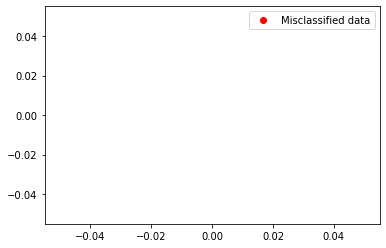

Epoch [1/500], Loss: 0.0000
Epoch [11/500], Loss: 0.0000
Epoch [21/500], Loss: 0.0000
Epoch [31/500], Loss: 0.0000
Epoch [41/500], Loss: 0.0000
Epoch [51/500], Loss: 0.0000
Epoch [61/500], Loss: 0.0000
Epoch [71/500], Loss: 0.0000
Epoch [81/500], Loss: 0.0000
Epoch [91/500], Loss: 0.0000
Epoch [101/500], Loss: 0.0000
Epoch [111/500], Loss: 0.0000
Epoch [121/500], Loss: 0.0000
Epoch [131/500], Loss: 0.0000
Epoch [141/500], Loss: 0.0000
Epoch [151/500], Loss: 0.0000
Epoch [161/500], Loss: 0.0000
Epoch [171/500], Loss: 0.0000
Epoch [181/500], Loss: 0.0000
Epoch [191/500], Loss: 0.0000
Epoch [201/500], Loss: 0.0000
Epoch [211/500], Loss: 0.0000
Epoch [221/500], Loss: 0.0000
Epoch [231/500], Loss: 0.0000
Epoch [241/500], Loss: 0.0000
Epoch [251/500], Loss: 0.0000
Epoch [261/500], Loss: 0.0000
Epoch [271/500], Loss: 0.0000
Epoch [281/500], Loss: 0.0000
Epoch [291/500], Loss: 0.0000
Epoch [301/500], Loss: 0.0000
Epoch [311/500], Loss: 0.0000
Epoch [321/500], Loss: 0.0000
Epoch [331/500], Loss

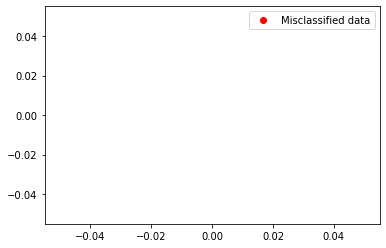

In [7]:
k_fold = 4
lambdas = np.logspace(-4, 0, 30)

# split data in k fold
k_indices = build_k_indices(y_train, k_fold)

# define lists to store the loss of training data and test data
rmse_tr = []
rmse_te = []
for k in range(k_fold):

    te_indice = k_indices[k]
    tr_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)]
    tr_indice = tr_indice.reshape(-1)
    y_te = y_train[te_indice]
    y_tr = y_train[tr_indice]
    x_te = x_train[te_indice]
    x_tr = x_train[tr_indice]
    
    train(features=x_tr,
        labels=y_tr,
        model=model,
        lossfunc=lossfunc,
        optimizer=optimizer,
        num_epoch=500)

    output = model(torch.from_numpy(x_te).float()).data.numpy()
    output = (output >= 1/2).astype(int)
    missed = np.absolute(y_te - output)
    print("Accuracy:", 100 * (len(y_te) - np.count_nonzero(missed)) / len(y_te) , "%")
    visualize(x_te, y_te, model)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d66177de-7ea1-46c8-aea6-26d701dd9bc9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>